# DATA Exploration

In [ ]:
!pip install efficientnet-pytorch --quiet
!pip install fastprogress --quiet 
import numpy as np
import pandas as pd
import random
from random import randint
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from pathlib import Path
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import imread
from pylab import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
from efficientnet_pytorch import EfficientNet
!pip install pytorch_ranger --quiet
from pytorch_ranger import Ranger
import gc
from fastprogress.fastprogress import master_bar, progress_bar
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [ ]:
all_label_csv = pd.read_csv('/content/drive/MyDrive/Weed Detection/labels.csv')
train_val_csv,test_csv = train_test_split(all_label_csv,test_size=0.2,random_state=42)

In [ ]:
train_val_csv.head()

,Filename,Label,Species
1643,20170501-144448-0.jpg,1,Lantana
6913,20171102-123253-1.jpg,2,Parkinsonia
2974,20170718-100346-2.jpg,0,Chinee apple
1576,20170501-142614-0.jpg,1,Lantana
1024,20170217-114152-0.jpg,0,Chinee apple


# Image w.r.t Label Visualisation

Samples with Label 0


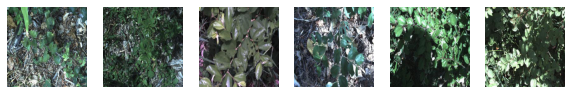

Samples with Label 1


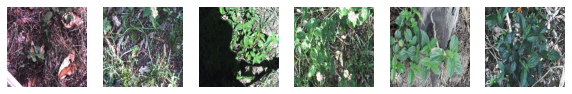

Samples with Label 2


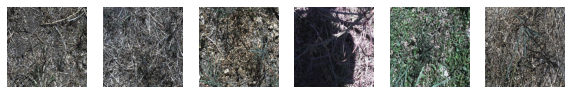

Samples with Label 3


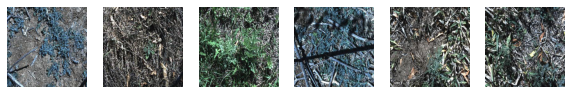

Samples with Label 4


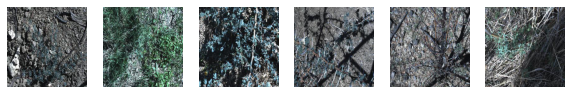

Samples with Label 5


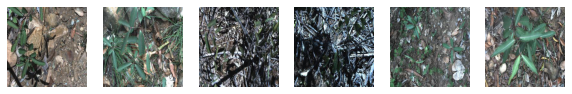

Samples with Label 6


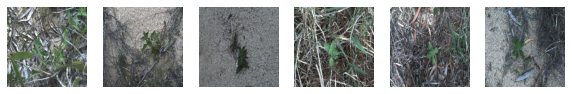

Samples with Label 7


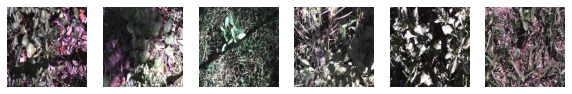

Samples with Label 8


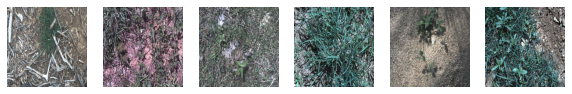

In [ ]:
print("Samples with Label 0")
imgs = train_csv[train_csv.Label==0]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 1")
imgs = train_csv[train_csv.Label==1]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 2")
imgs = train_csv[train_csv.Label==2]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 3")
imgs = train_csv[train_csv.Label==3]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 4")
imgs = train_csv[train_csv.Label==4]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 5")
imgs = train_csv[train_csv.Label==5]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 6")
imgs = train_csv[train_csv.Label==6]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 7")
imgs = train_csv[train_csv.Label==7]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples with Label 8")
imgs = train_csv[train_csv.Label==8]['Filename'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/images/')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}')
    ax.imshow(img)
    ax.axis('off')
plt.show()

# Building datasets and dataloaders 

In [ ]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0])
    image = imread(img_path)
    label = self.csv_file.iloc[idx, 1]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    return image,label

def get_transforms(phase):
    imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
    image_size=384
    train_tfms = A.Compose([
        A.Resize(image_size, image_size),
        A.RandomCrop(height=256, width=256),### centercrop ###
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        ToTensor(normalize=imagenet_stats)
        ])
    test_tfms = A.Compose([
        A.Resize(image_size, image_size),
        ToTensor(normalize=imagenet_stats)
        ])
    if phase=='train':
      return train_tfms
    else:
      return test_tfms

In [ ]:
### creating train and test datasets
train_dataset = dataset(train_csv,'/content/images/','train')
test_dataset = dataset(test_csv,'/content/images/','test')
val_dataset = dataset(val_csv,'/content/images/','val')
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}
print(dataset_sizes)

In [ ]:
### visualising datasets
a=randint(0,10000)
print("VISUALISING TRAIN DATASET")
for i in range(a,a+10):
  image, label = train_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING TEST DATASET")
b=randint(0,3500)
for i in range(b,b+10):
  image, label = test_dataset[i]
  print(i,'\t', image.shape,'\t', label)

In [ ]:
dataloader={}
def load_data(trn_idx, val_idx):
  train_dataset = dataset(train_val_csv.iloc[trn_idx],'/content/drive/MyDrive/Weed Detection/data','train')
  val_dataset = dataset(train_val_csv.iloc[val_idx],'/content/drive/MyDrive/Weed Detection/data','val')
  dataset_sizes['train'] = len(train_dataset)
  dataset_sizes['val'] = len(val_dataset)
  dataloader['train'] = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
  dataloader['val'] = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataset = dataset(test_csv,'/content/drive/MyDrive/Weed Detection/data','test')
dataset_sizes = {'test':len(test_dataset), 'train':0, 'val':0}
dataloader['test'] = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
### visualing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  print('img size--',img_batch.size(2))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

print('Visualising A Batch:')

for i, sample_batch in enumerate(dataloader['train']):
  img, label = sample_batch
  print(i, img.size(), label.shape)
  if i==3:
    show_batch(sample_batch)
    break

# Trainer

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    mb = master_bar(range(num_epochs))

    for epoch in mb:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for img_batch, labels in progress_bar(dataloader[phase],parent=mb):
                img_batch = img_batch.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img_batch)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_batch.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                scheduler.step(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            torch.save(model.state_dict(),f'/content/drive/MyDrive/Weed Detection/last_wt_effb2_256_1.pth')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(),f'/content/drive/MyDrive/Weed Detection/best_wt_effb2_256_1.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    torch.save(model.state_dict(),f'/content/drive/MyDrive/Weed Detection/best_wt_effb2_256_1.pth')
    return model

# Training model

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b2',num_classes=9)
model.load_state_dict(torch.load('/content/drive/MyDrive/Weed Detection/best_wt_effb2_256_1.pth'))

device = torch.device("cuda")
model = model.to(device)

Loaded pretrained weights for efficientnet-b2


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters(), lr= 1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5,mode='max',patience=2,threshold=0.0005, verbose=True)

gc.collect()

7

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train_val_csv)):
  print('`'*30,'Fold ',(fold+1),' of ', 5, '`'*30)
  load_data(trn_idx, val_idx)
  trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=3)

`````````````````````````````` Fold  1  of  5 ``````````````````````````````


Epoch 0/2
----------
train Loss: 0.2140 Acc: 0.9281
val Loss: 0.0743 Acc: 0.9757

Epoch 1/2
----------
train Loss: 0.2074 Acc: 0.9296
val Loss: 0.0740 Acc: 0.9761

Epoch 2/2
----------
train Loss: 0.2165 Acc: 0.9266
val Loss: 0.0759 Acc: 0.9747

Training complete in 9m 46s
Best val Acc: 0.976089
`````````````````````````````` Fold  2  of  5 ``````````````````````````````


Epoch 0/2
----------
train Loss: 0.2137 Acc: 0.9316
Epoch    19: reducing learning rate of group 0 to 5.0000e-05.
val Loss: 0.0698 Acc: 0.9714

Epoch 1/2
----------
train Loss: 0.2077 Acc: 0.9322
val Loss: 0.0696 Acc: 0.9714

Epoch 2/2
----------
train Loss: 0.2146 Acc: 0.9283
val Loss: 0.0708 Acc: 0.9714

Training complete in 9m 47s
Best val Acc: 0.971449
`````````````````````````````` Fold  3  of  5 ``````````````````````````````


Epoch 0/2
----------
train Loss: 0.2006 Acc: 0.9343
Epoch    22: reducing learning rate of group 0 to 2.5000e-05.
val Loss: 0.0910 Acc: 0.9693

Epoch 1/2
----------
train Loss: 0.2051 Acc: 0.9302
val Loss: 0.0866 Acc: 0.9711

Epoch 2/2
----------
train Loss: 0.2055 Acc: 0.9330
val Loss: 0.0867 Acc: 0.9711

Training complete in 9m 44s
Best val Acc: 0.971082
`````````````````````````````` Fold  4  of  5 ``````````````````````````````


Epoch 0/2
----------
train Loss: 0.2016 Acc: 0.9327
Epoch    25: reducing learning rate of group 0 to 1.2500e-05.
val Loss: 0.0957 Acc: 0.9629

Epoch 1/2
----------
train Loss: 0.2051 Acc: 0.9306
val Loss: 0.0957 Acc: 0.9625

Epoch 2/2
----------
train Loss: 0.2051 Acc: 0.9320
val Loss: 0.0946 Acc: 0.9636

Training complete in 9m 46s
Best val Acc: 0.963584
`````````````````````````````` Fold  5  of  5 ``````````````````````````````


Epoch 0/2
----------
train Loss: 0.2034 Acc: 0.9310
Epoch    28: reducing learning rate of group 0 to 6.2500e-06.
val Loss: 0.1063 Acc: 0.9636

Epoch 1/2
----------
train Loss: 0.2055 Acc: 0.9340
val Loss: 0.1047 Acc: 0.9650

Epoch 2/2
----------
train Loss: 0.2004 Acc: 0.9334
val Loss: 0.1045 Acc: 0.9647

Training complete in 9m 48s
Best val Acc: 0.965012


# Testing our Model 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_csv.Species.value_counts(normalize=True)

Negative          0.524272
Siam weed         0.063678
Parthenium        0.061393
Lantana           0.061393
Chinee apple      0.060822
Prickly acacia    0.059966
Rubber vine       0.057110
Parkinsonia       0.056825
Snake weed        0.054540
Name: Species, dtype: float64

In [ ]:
test_dataset = dataset(test_csv,'/content/images/','test')
dataloader['test'] = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
trained_model.eval()   # Set model to evaluate mode
prediction = torch.tensor([],dtype=torch.int64)
prediction = prediction.to(device)
# Iterate over test data.
for img_batch, labels in dataloader['test']:
    img_batch = img_batch.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
      outputs = trained_model(img_batch)
      _, preds = torch.max(outputs, 1)
    prediction = torch.cat((prediction,preds),0)

print("Test set score: ", accuracy_score(np.array(test_csv.iloc[:,1]),prediction.detach().cpu().numpy()))

Test set score:  0.96087949743004
